In [1]:
import kagglehub
dataset_path = kagglehub.dataset_download('bhavikjikadara/dog-and-cat-classification-dataset')
print('Data source import complete.')

c:\Users\lucas\OneDrive - Amelyer Company\Documentos\Projetos Python\Dogs vs Cats\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data source import complete.


In [2]:
import os
directory = os.path.join(dataset_path, 'PetImages')
os.listdir(directory)

['Cat', 'Dog']

In [3]:
images = []
labels = []

try:
  for foldr in os.listdir(directory):
    for filee in os.listdir(os.path.join(directory, foldr)):
      images.append(os.path.join(foldr, filee))
      labels.append(foldr)
        
except Exception as e:
  print(f'Error: {e}')

In [4]:
import pandas as pd

all_df = pd.DataFrame({
    'Images': images,
    'Labels': labels
    })

all_df.info()
all_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24998 entries, 0 to 24997
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Images  24998 non-null  object
 1   Labels  24998 non-null  object
dtypes: object(2)
memory usage: 390.7+ KB


,Images,Labels
0,Cat\0.jpg,Cat
1,Cat\1.jpg,Cat
2,Cat\10.jpg,Cat
3,Cat\100.jpg,Cat
4,Cat\1000.jpg,Cat
...,...,...
24993,Dog\9995.jpg,Dog
24994,Dog\9996.jpg,Dog
24995,Dog\9997.jpg,Dog
24996,Dog\9998.jpg,Dog


C:\Users\lucas\AppData\Local\Temp\ipykernel_16744\2285069866.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Labels', data=all_df, palette=colors)


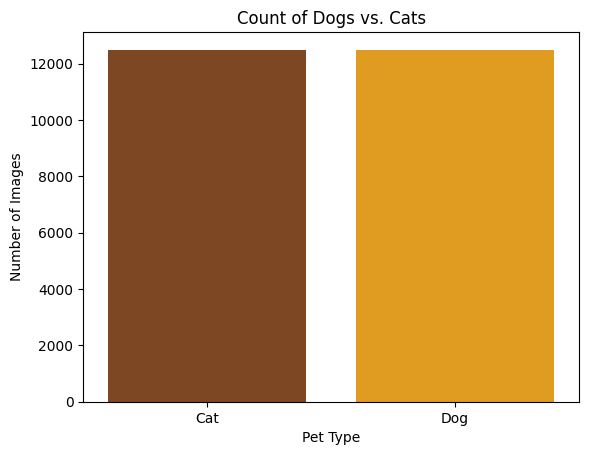

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

colors = ['#8B4513', 'orange'] # using a hex code for a specific brown

sns.countplot(x='Labels', data=all_df, palette=colors)
plt.title('Count of Dogs vs. Cats')
plt.xlabel('Pet Type')
plt.ylabel('Number of Images')
plt.show()

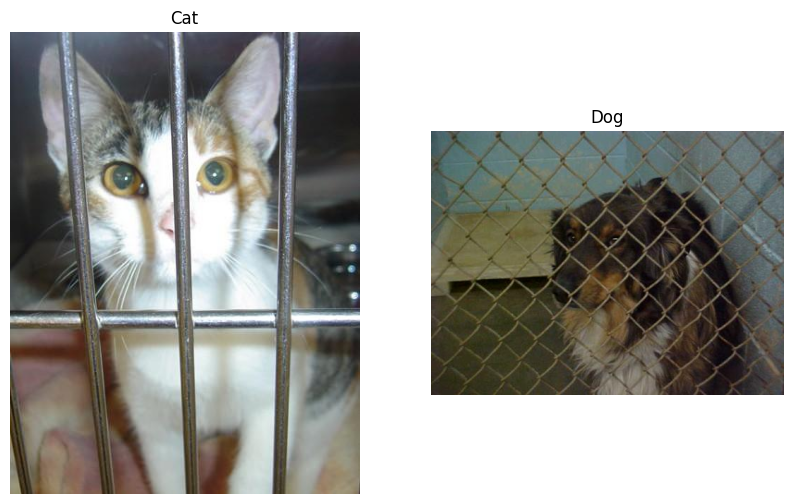

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import os

plt.figure(figsize=(10, 6))

for i, label in enumerate(all_df['Labels'].unique()):
    sample = all_df[all_df['Labels'] == label].sample(1).iloc[0]
    img_path = os.path.join(directory, sample['Images'])
    
    img = mpimg.imread(img_path) 

    plt.subplot(1, len(all_df['Labels'].unique()), i+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
    
plt.show()

In [7]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_df, test_df = train_test_split(all_df, test_size=0.2, random_state=42, stratify=all_df['Labels'])

In [8]:
# Transfer learning models are best not to be rescaled (because they are already rescaled during their original training, and if you try to rescale them again, the validation accuracy will drop to nearly the half).

trainimgen = ImageDataGenerator( 
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    shear_range=0.2
    )

train_data = trainimgen.flow_from_dataframe(
    dataframe=train_df,
    directory=directory,
    x_col='Images',
    y_col='Labels',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=16,
)

Found 19998 validated image filenames belonging to 2 classes.


In [9]:
testimgen = ImageDataGenerator()


test_data = testimgen.flow_from_dataframe(
    dataframe=test_df,
    directory=directory,
    x_col='Images',
    y_col='Labels',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=16,
    shuffle=False # For test data, it's crucial to set shuffle=False. This ensures the prediction order matches the label order, which is necessary for correct evaluation with metrics like a confusion matrix.
)

Found 5000 validated image filenames belonging to 2 classes.


In [10]:
# ResNet50 model
import tensorflow.keras.applications as ap
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout

processing = ap.ResNet50(weights='imagenet', include_top=False)

for layer in processing.layers[:5]:
    layer.trainable = False

Model = Sequential(
    [
        processing,
        GlobalAveragePooling2D(),

        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ]
)


In [11]:
Model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, None, None,     │    23,587,712 │
│                                 │ 2048)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,145,281 (92.11 MB)

 Trainable params: 24,082,561 (91.87 MB)

 Non-trainable params: 62,720 (245.00 KB)

In [12]:
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.callbacks as cb

callbacky = cb.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
Model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
Model.fit(
    train_data,
    epochs=5,
    validation_data=test_data,
    callbacks=[callbacky]
    )

Epoch 1/5
 880/1250 ━━━━━━━━━━━━━━━━━━━━ 22:08 4s/step - accuracy: 0.9390 - loss: 0.1481

c:\Users\lucas\OneDrive - Amelyer Company\Documentos\Projetos Python\Dogs vs Cats\.venv\Lib\site-packages\PIL\TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4749s 4s/step - accuracy: 0.9625 - loss: 0.0985 - val_accuracy: 0.9604 - val_loss: 0.1375
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4885s 4s/step - accuracy: 0.9751 - loss: 0.0654 - val_accuracy: 0.9844 - val_loss: 0.0452
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5473s 4s/step - accuracy: 0.9805 - loss: 0.0534 - val_accuracy: 0.9876 - val_loss: 0.0344
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5792s 5s/step - accuracy: 0.9825 - loss: 0.0480 - val_accuracy: 0.9792 - val_loss: 0.0526
Epoch 5/5
 528/1250 ━━━━━━━━━━━━━━━━━━━━ 46:32 4s/step - accuracy: 0.9883 - loss: 0.0348

AbortedError: Graph execution error:

Detected at node StatefulPartitionedCall/gradient_tape/sequential_1/resnet50_1/conv3_block1_0_conv_1/convolution/Conv2DBackpropInput defined at (most recent call last):
<stack traces unavailable>
Operation received an exception:Status: 1, message: could not create a primitive, in file tensorflow/core/kernels/mkl/mkl_conv_grad_input_ops.cc:546
	 [[{{node StatefulPartitionedCall/gradient_tape/sequential_1/resnet50_1/conv3_block1_0_conv_1/convolution/Conv2DBackpropInput}}]] [Op:__inference_multi_step_on_iterator_44945]

In [14]:
Model.evaluate(test_data)

313/313 ━━━━━━━━━━━━━━━━━━━━ 260s 827ms/step - accuracy: 0.9824 - loss: 0.0491


[0.04906430095434189, 0.9824000000953674]

In [15]:
# Plotting a Confusion Matrix
from sklearn.metrics import confusion_matrix
import numpy as np

preds = Model.predict(test_data)

# Converting probabilities to binary classes (0 or 1)
# The threshold 0.5 is standard for binary classification with a sigmoid activation
preds_classes = (preds > 0.5).astype(int).flatten()

313/313 ━━━━━━━━━━━━━━━━━━━━ 257s 813ms/step


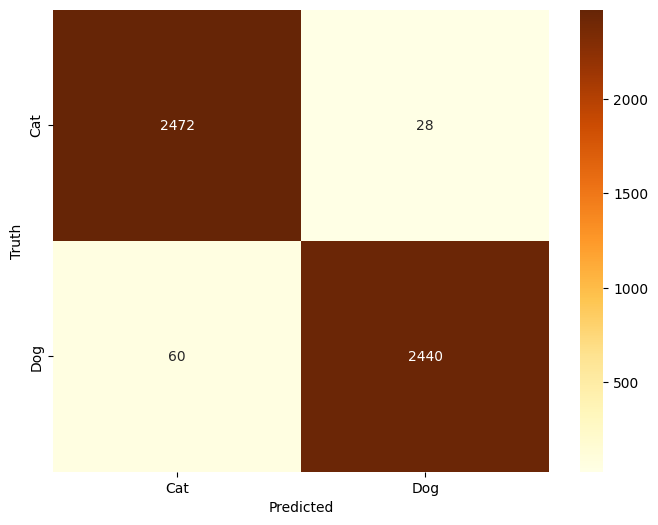

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

true_labels = test_data.classes

cm = confusion_matrix(true_labels, preds_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrBr', 
            xticklabels=list(test_data.class_indices.keys()), 
            yticklabels=list(test_data.class_indices.keys()))
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [17]:
Model.save(r'C:\Users\lucas\OneDrive - Amelyer Company\Documentos\Projetos Python\Dogs vs Cats\models\ResNet50_Model.keras')